In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras

In [2]:
(X_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data()
X_train = X_train[y_train == 3]

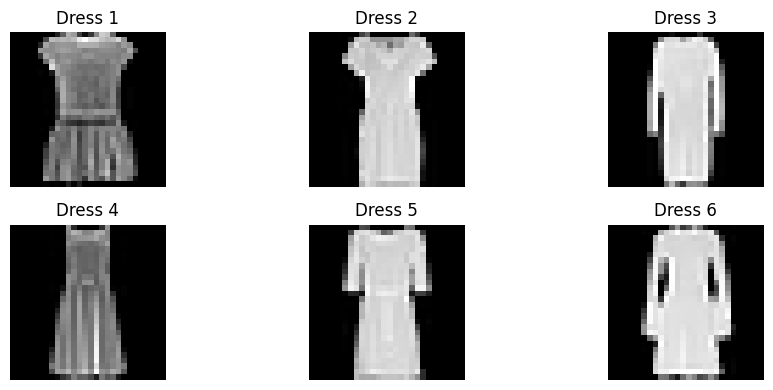

In [27]:
# lets look at the first 6 images
plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f'Dress {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [23]:
X_train.shape

(6000, 28, 28)

In [4]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5  # to [-1, 1]
    return image


In [46]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(
        factor=0.015,  
        fill_mode='constant',
        fill_value=0.0  
    ),
    layers.RandomZoom(
        height_factor=(-0.01, 0.02),  
        width_factor=(-0.01, 0.02),
        fill_mode='constant',
        fill_value=0.0  
    ), 
    layers.RandomTranslation(
        height_factor=0.01,
        width_factor=0.01,
        fill_mode='constant',
        fill_value=0.0  
    )
])

In [47]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.map(preprocess).batch(batch_size)
dataset = dataset.shuffle(1024)
dataset = dataset.map(lambda x: data_augmentation(x), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

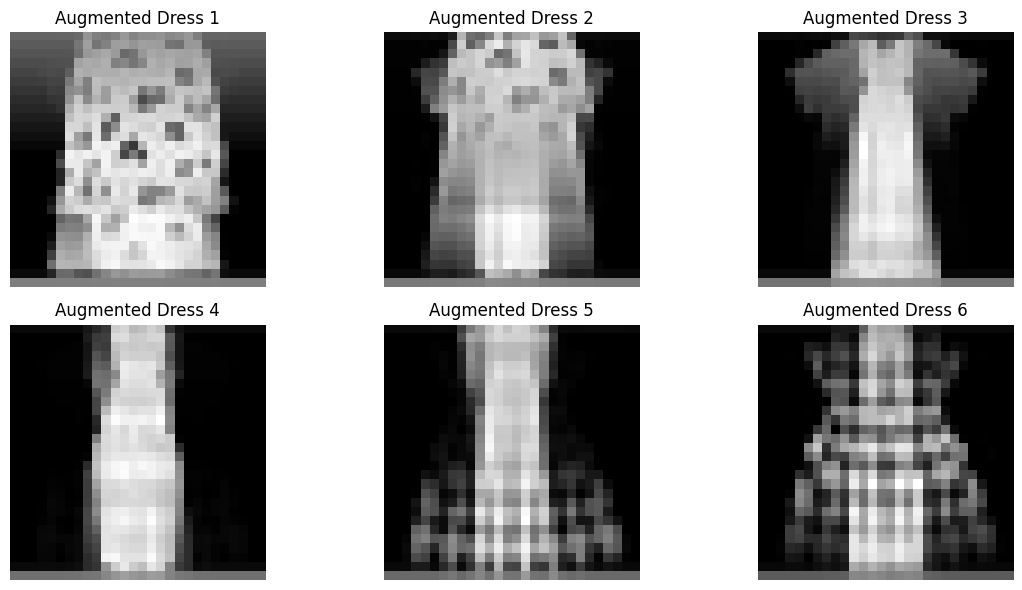

In [49]:
augmented_images = next(iter(dataset))

# Display 6 sample images
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'Augmented Dress {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
latent_dim = 100

# Model 1: Basic DCGAN-style
def make_generator_model_1():
    inputs = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(7*7*256, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    outputs = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', 
                                   use_bias=False, activation='tanh')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="generator_1")

def make_discriminator_model_1():
    inputs = layers.Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(1)(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="discriminator_1")




In [34]:
# Model 2: Residual GAN
def make_generator_model_2():
    def res_block_gen(x, filters):
        shortcut = x
        x = layers.Conv2DTranspose(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        return layers.Add()([x, shortcut])

    inputs = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(7*7*256, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((7, 7, 256))(x)
    
    x = res_block_gen(x, 256)
    
    x = layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = res_block_gen(x, 128)
    
    x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    outputs = layers.Conv2DTranspose(1, 7, padding='same', activation='tanh')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="generator_2")

def make_discriminator_model_2():
    def res_block_disc(x, filters):
        shortcut = layers.Conv2D(filters, 1, padding='same')(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        return layers.Add()([x, shortcut])

    inputs = layers.Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(64, 5, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = res_block_disc(x, 64)
    
    x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="discriminator_2")


In [35]:
# Model 3: Deep Fully-Connected GAN
def make_generator_model_3():
    inputs = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(512, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(1024, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(2048, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(1024, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(512, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(28*28, activation='tanh')(x)
    outputs = layers.Reshape((28, 28, 1))(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="generator_3")

def make_discriminator_model_3():
    inputs = layers.Input(shape=(28, 28, 1))
    
    x = layers.Flatten()(inputs)
    
    x = layers.Dense(2048)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(1)(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="discriminator_3")

In [36]:
generator = make_generator_model_1()
discriminator = make_discriminator_model_1()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)


In [37]:

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Label smoothing for real img is 0.9
        real_labels = tf.ones_like(real_output) * 0.9
        fake_labels = tf.zeros_like(fake_output)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss_real = cross_entropy(real_labels, real_output)
        disc_loss_fake = cross_entropy(fake_labels, fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss




def train(dataset, epochs):
    seed = tf.random.normal([16, latent_dim])  
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")
            generate_and_save_images(generator, epoch, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.close()


In [ ]:
epochs = 100
train(dataset, epochs)

Epoch 0, Gen Loss: 0.7821744680404663, Disc Loss: 1.379531741142273
Epoch 10, Gen Loss: 0.7860422134399414, Disc Loss: 1.3974119424819946
Epoch 20, Gen Loss: 0.809931755065918, Disc Loss: 1.3802008628845215
Epoch 30, Gen Loss: 0.8219653367996216, Disc Loss: 1.3708893060684204


In [32]:
generator = make_generator_model_2()
discriminator = make_discriminator_model_2()
_ = generator(tf.random.normal([1, latent_dim]))
_ = discriminator(tf.random.normal([1, 28, 28, 1]))

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

cross_entropy = keras.losses.BinaryCrossentropy()

train(dataset, epochs)

Epoch 0, Gen Loss: 0.7468366622924805, Disc Loss: 1.4165185689926147
Epoch 10, Gen Loss: 0.8000950813293457, Disc Loss: 1.3829929828643799
Epoch 20, Gen Loss: 0.7490496039390564, Disc Loss: 1.2902199029922485
Epoch 30, Gen Loss: 0.8194082975387573, Disc Loss: 1.3191044330596924
Epoch 40, Gen Loss: 0.7977607250213623, Disc Loss: 1.376704216003418
Epoch 50, Gen Loss: 0.8735114336013794, Disc Loss: 1.354561686515808
Epoch 60, Gen Loss: 0.9203472137451172, Disc Loss: 1.3129515647888184
Epoch 70, Gen Loss: 0.8887611627578735, Disc Loss: 1.432393193244934
Epoch 80, Gen Loss: 0.8372214436531067, Disc Loss: 1.3467092514038086
Epoch 90, Gen Loss: 0.8195568323135376, Disc Loss: 1.3724143505096436


In [38]:
generator = make_generator_model_3()
discriminator = make_discriminator_model_3()
_ = generator(tf.random.normal([1, latent_dim]))
_ = discriminator(tf.random.normal([1, 28, 28, 1]))

lr_gen = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=50 * (len(X_train) // batch_size),
    decay_rate=0.5,
    staircase=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

cross_entropy = keras.losses.BinaryCrossentropy()

train(dataset, epochs)

Epoch 0, Gen Loss: 0.7749286890029907, Disc Loss: 1.3557648658752441
Epoch 10, Gen Loss: 0.9140946269035339, Disc Loss: 1.3063955307006836
Epoch 20, Gen Loss: 0.8071285486221313, Disc Loss: 1.3629893064498901
Epoch 30, Gen Loss: 0.8936246037483215, Disc Loss: 1.3415015935897827
Epoch 40, Gen Loss: 0.9541235566139221, Disc Loss: 1.2332267761230469
Epoch 50, Gen Loss: 0.7725262641906738, Disc Loss: 1.2608652114868164
Epoch 60, Gen Loss: 0.9156294465065002, Disc Loss: 1.2915829420089722
Epoch 70, Gen Loss: 0.9569312334060669, Disc Loss: 1.2750792503356934
Epoch 80, Gen Loss: 0.887984037399292, Disc Loss: 1.3063437938690186
Epoch 90, Gen Loss: 1.082348108291626, Disc Loss: 1.253327488899231


In [8]:
model_1_history = '''Epoch 0, Gen Loss: 0.757530152797699, Disc Loss: 1.4179482460021973
Epoch 10, Gen Loss: 0.8844344615936279, Disc Loss: 1.3443803787231445
Epoch 20, Gen Loss: 0.8620001077651978, Disc Loss: 1.2983183860778809
Epoch 30, Gen Loss: 0.8404276967048645, Disc Loss: 1.3058398962020874
Epoch 40, Gen Loss: 0.8980423808097839, Disc Loss: 1.3563501834869385
Epoch 50, Gen Loss: 0.8011188507080078, Disc Loss: 1.370927333831787
Epoch 60, Gen Loss: 0.7822796106338501, Disc Loss: 1.3593897819519043
Epoch 70, Gen Loss: 0.9400210380554199, Disc Loss: 1.3812066316604614
Epoch 80, Gen Loss: 0.8865818381309509, Disc Loss: 1.3398232460021973
Epoch 90, Gen Loss: 0.8674373626708984, Disc Loss: 1.2364025115966797'''

model_2_history = '''Epoch 0, Gen Loss: 0.7468366622924805, Disc Loss: 1.4165185689926147
Epoch 10, Gen Loss: 0.8000950813293457, Disc Loss: 1.3829929828643799
Epoch 20, Gen Loss: 0.7490496039390564, Disc Loss: 1.2902199029922485
Epoch 30, Gen Loss: 0.8194082975387573, Disc Loss: 1.3191044330596924
Epoch 40, Gen Loss: 0.7977607250213623, Disc Loss: 1.376704216003418
Epoch 50, Gen Loss: 0.8735114336013794, Disc Loss: 1.354561686515808
Epoch 60, Gen Loss: 0.9203472137451172, Disc Loss: 1.3129515647888184
Epoch 70, Gen Loss: 0.8887611627578735, Disc Loss: 1.432393193244934
Epoch 80, Gen Loss: 0.8372214436531067, Disc Loss: 1.3467092514038086
Epoch 90, Gen Loss: 0.8195568323135376, Disc Loss: 1.3724143505096436'''

model_3_history = '''Epoch 0, Gen Loss: 0.7749286890029907, Disc Loss: 1.3557648658752441
Epoch 10, Gen Loss: 0.9140946269035339, Disc Loss: 1.3063955307006836
Epoch 20, Gen Loss: 0.8071285486221313, Disc Loss: 1.3629893064498901
Epoch 30, Gen Loss: 0.8936246037483215, Disc Loss: 1.3415015935897827
Epoch 40, Gen Loss: 0.9541235566139221, Disc Loss: 1.2332267761230469
Epoch 50, Gen Loss: 0.7725262641906738, Disc Loss: 1.2608652114868164
Epoch 60, Gen Loss: 0.9156294465065002, Disc Loss: 1.2915829420089722
Epoch 70, Gen Loss: 0.9569312334060669, Disc Loss: 1.2750792503356934
Epoch 80, Gen Loss: 0.887984037399292, Disc Loss: 1.3063437938690186
Epoch 90, Gen Loss: 1.082348108291626, Disc Loss: 1.253327488899231'''

In [20]:
def plot_training_losses(log_str, title):
    epochs = []
    gen_losses = []
    disc_losses = []
    
    lines = log_str.strip().split('\n')
    
    for line in lines:
        if not line:
            continue
            
        clean_line = line.replace(',', '').replace(':', '')
        parts = clean_line.split()
        
        try:

            epoch_idx = parts.index('Epoch') + 1
            gen_idx = parts.index('Gen') + 2 
            disc_idx = parts.index('Disc') + 2 
            

            epoch = int(parts[epoch_idx])
            gen_loss = float(parts[gen_idx])
            disc_loss = float(parts[disc_idx])
            

            epochs.append(epoch)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)
            
        except (ValueError, IndexError) as e:
            print(f"Error parsing line: {line}")
            print(f"Error: {str(e)}")
            continue
    
    plt.figure(figsize=(10, 5))
    
    plt.plot(epochs, gen_losses, label='Generator Loss')
    plt.plot(epochs, disc_losses, label='Discriminator Loss')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    
    plt.tight_layout()
    plt.show()


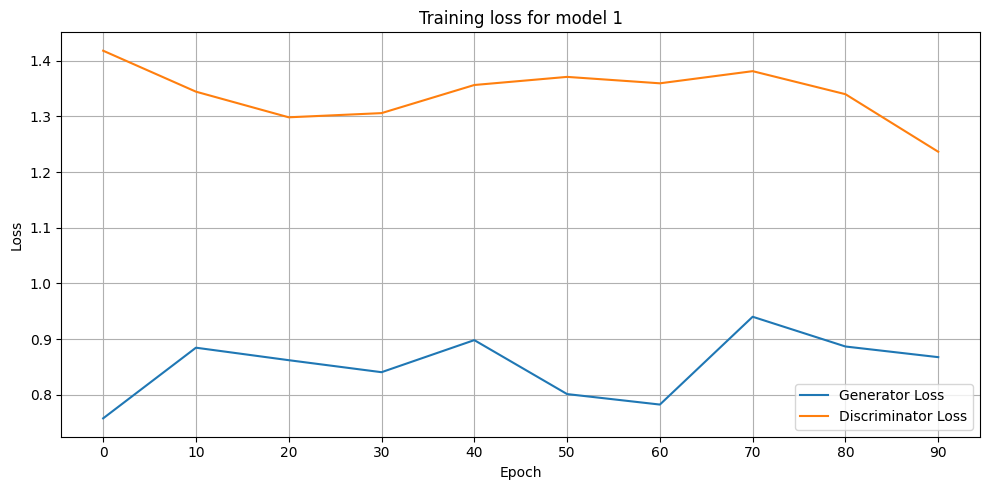

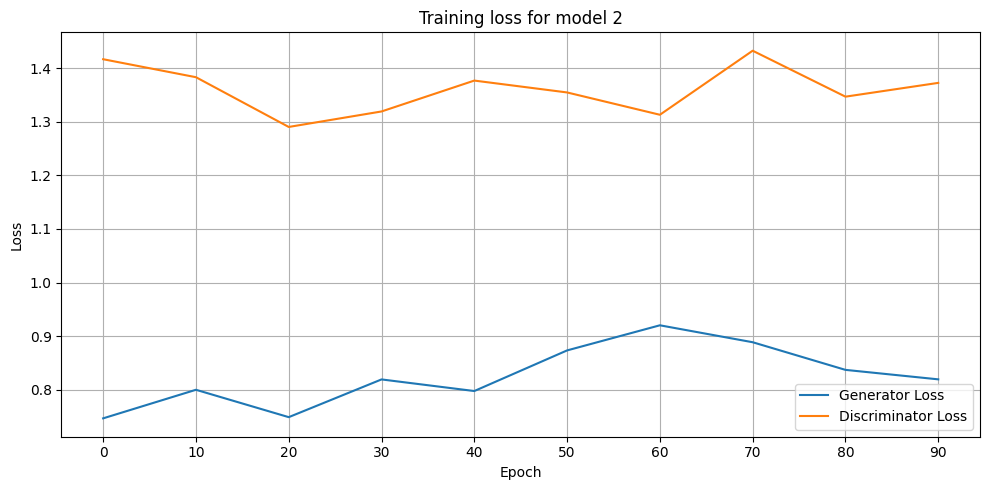

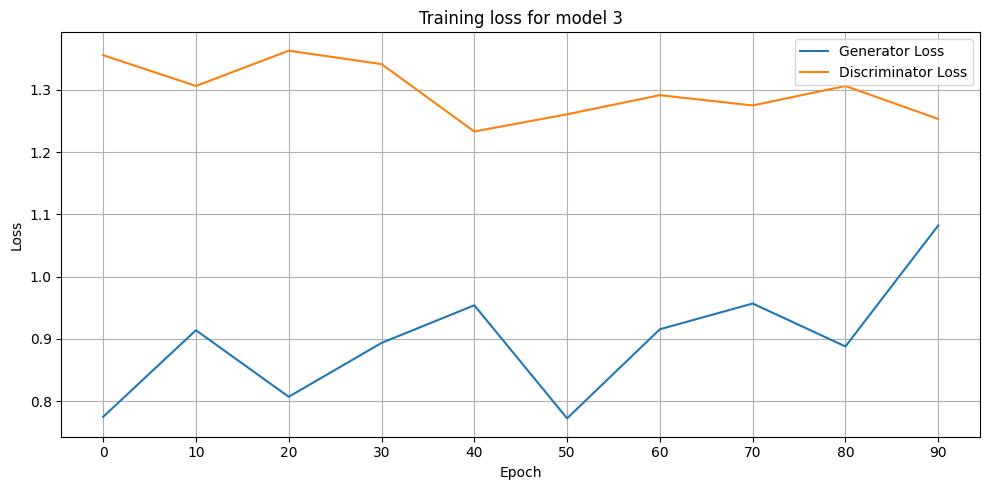

In [22]:
plot_training_losses(model_1_history, 'Training loss for model 1')
plot_training_losses(model_2_history, 'Training loss for model 2')
plot_training_losses(model_3_history, 'Training loss for model 3')